# Data Science
- Student: Dmytro Geleshko
- Group: IP-91
- Var: 6

# Imports

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import tensorflow as tf

# Config

In [51]:
# var 6
np.random.seed(6)
plt.rcParams["figure.figsize"] = (20, 8)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.3f}".format

# Load data

In [52]:
df = pd.read_csv("mod_data.csv", index_col="date", parse_dates=True, dtype=np.float32)
df

,close,volume,volume_norm,log_close,log_fit,log_diff,month_sin,month_cos,year_sin,year_cos
date,,,,,,,,,,
2010-07-18,0.100,80.000,-0.674,-2.303,-2.298,-0.005,-0.095,-0.995,-0.266,-0.964
2010-07-19,0.100,570.000,-0.672,-2.303,-2.287,-0.016,-0.297,-0.955,-0.283,-0.959
2010-07-20,0.100,260.000,-0.673,-2.303,-2.276,-0.027,-0.486,-0.874,-0.299,-0.954
2010-07-21,0.100,580.000,-0.672,-2.303,-2.264,-0.038,-0.655,-0.756,-0.316,-0.949
2010-07-22,0.100,"2,160.000",-0.666,-2.303,-2.253,-0.049,-0.796,-0.605,-0.332,-0.943
...,...,...,...,...,...,...,...,...,...,...
2021-11-21,"58,714.301","40,980.000",-0.523,10.980,10.243,0.738,-0.863,-0.505,-0.643,0.766
2021-11-22,"56,308.801","76,450.000",-0.392,10.939,10.244,0.695,-0.948,-0.317,-0.630,0.777
2021-11-23,"57,573.199","72,480.000",-0.406,10.961,10.245,0.716,-0.993,-0.116,-0.616,0.787


In [53]:
df.index.dtype, df.dtypes

(dtype('<M8[ns]'),
 close          float32
 volume         float32
 volume_norm    float32
 log_close      float32
 log_fit        float32
 log_diff       float32
 month_sin      float32
 month_cos      float32
 year_sin       float32
 year_cos       float32
 dtype: object)

In [54]:
features = ["volume_norm", "log_diff", "month_sin", "month_cos", "year_sin", "year_cos"]

# Load coef arrays

In [55]:
log_fit_coef = np.load("saved_params/log_fit_coef.npy")
log_fit_coef

array([[-37.26653031],
       [  5.62681681]])

In [56]:
vol_mean_std = np.load("saved_params/volume_mean_std.npy")
vol_mean_std

array([182627.71029164, 270991.24624698])

In [62]:
def get_log_fit(start_i, size, coef):
    F = np.ones((size, 2))
    F[:, 1] = np.log(np.arange(start_i + 500, start_i + 500 + size))
    result = np.dot(F, coef)
    return result.reshape(-1)

# Load new data

In [17]:
url = "https://www.investing.com/crypto/bitcoin/btc-usd-historical-data"

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

dfs = pd.read_html(r.text, attrs = {"id": "curr_table"}, index_col="Date", parse_dates=True)[0]

In [26]:
dfs.sort_index(inplace=True)

if dfs.index[-1] > df.index[-1]:
    dfs = dfs[df.index[-1]:]
    
dfs

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-10-30,"61,838.800","62,235.000","62,353.000","60,756.000",2.24K,-0.64%
2021-10-31,"61,330.000","61,838.800","62,414.000","60,021.000",2.42K,-0.82%
2021-11-01,"60,927.000","61,330.000","62,485.000","59,595.600",4.81K,-0.66%
2021-11-02,"63,249.000","60,927.000","64,263.400","60,661.000",5.20K,3.81%
2021-11-03,"62,904.000","63,249.000","63,556.000","60,624.000",4.76K,-0.55%
2021-11-04,"61,422.800","62,904.000","63,060.200","60,733.000",2.93K,-2.35%
2021-11-05,"61,016.400","61,422.800","62,598.000","60,746.300",2.26K,-0.66%
2021-11-06,"61,496.000","61,016.400","61,583.000","60,100.000",2.93K,0.79%
2021-11-07,"63,259.100","61,495.000","63,279.000","61,400.000",3.23K,2.87%


# Load Model

In [58]:
model = tf.keras.models.load_model("saved_model/v2.h5")

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 42)                8232      
                                                                 
 dense (Dense)               (None, 7)                 301       
                                                                 
Total params: 8,533
Trainable params: 8,533
Non-trainable params: 0
_________________________________________________________________


In [63]:
def get_forecast(df, features, model, coef):
    # vals
    x = df[features].iloc[-21:].values.reshape((1, 21, 6))
    y = model.predict(x)[0]
    
    #dates
    dates_x = pd.date_range(df.index[-21], periods=28, freq="D")
    dates_y = dates_x[-7:]
    dates_x = dates_x[:-7]

    # convert X
    x = np.exp(df["log_diff"].iloc[-21:].values + df["log_fit"].iloc[-21:].values)
    
    # convert y def 
    y = np.exp(y + get_log_fit(df.shape[0], size=7, coef=coef))
    
    #plot
    plt.plot(dates_x, x, label="history", color="blue")
    plt.plot(dates_y, y, label="forecast", color="red")
    plt.plot([dates_x[-1], dates_y[0]], [x[-1], y[0]], color="red", linestyle="--")
    plt.legend()
    plt.plot()

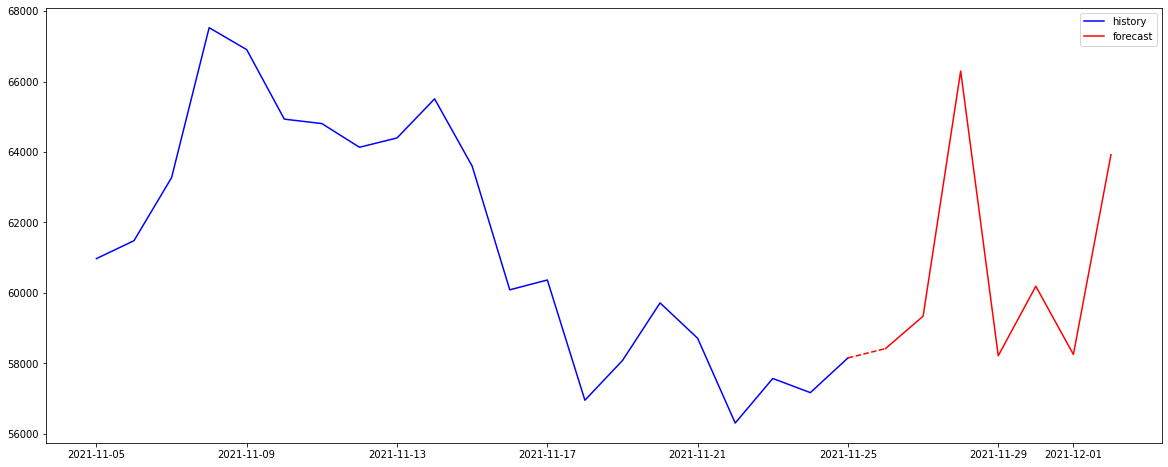

In [64]:
get_forecast(df, features, model, log_fit_coef)